In [1]:
%matplotlib inline
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import FashionMNIST
import torchvision.transforms as transforms
from torch.utils.data import DataLoader


In [2]:
# Espace latent 2 dimensions

latent_dims = 2
num_epochs = 500
batch_size = 1
capacity = 16
learning_rate = 1e-3
variational_beta = 0.01
use_gpu = True



# # 10-d Espace latent en 10 dimensions, qui correspond à un Autoencoder simple (à comparer avec le VAE 
# et un espace latent de 2 dimensions)
# latent_dims = 10
# num_epochs = 100
# batch_size = 128
# capacity = 64
# learning_rate = 1e-3
# variational_beta = 1
# use_gpu = True

# Chargement des données 


In [3]:
import os
import descriptors
import numpy as np

dict_r = np.load('data_dict.npy', allow_pickle=True).item()

train_db = np.zeros([len(dict_r['env']),2,750])
i = 0
for sample in dict_r['env']:
    train_db[i,:,:] = sample
    i+=1
    
train_dataset =  torch.utils.data.TensorDataset(torch.from_numpy(train_db))
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size, shuffle=True)

test_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size, shuffle=True)

# Defintion du VAE 

Kernel Size = 4 papier qui explique pourquoi: https://distill.pub/2016/deconv-checkerboard/

In [5]:
from VAEAudio import* 
    
def vae_loss(recon_x, x, mu, logvar):
    # recon_x is the probability of a multivariate Bernoulli distribution p.
    # -log(p(x)) is then the pixel-wise binary cross-entropy.
    # Averaging or not averaging the binary cross-entropy over all pixels here
    # is a subtle detail with big effect on training, since it changes the weight
    # we need to pick for the other loss term by several orders of magnitude.
    # Not averaging is the direct implementation of the negative log likelihood,
    # but averaging makes the weight of the other loss term independent of the image resolution.
    recon_loss = F.binary_cross_entropy(recon_x.view(-1, batch_size*2*750), x.view(-1, batch_size*2*750), reduction='sum')
    
    # KL-divergence between the prior distribution over latent vectors
    # (the one we are going to sample from when generating new images)
    # and the distribution estimated by the generator for the given image.
    kldivergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    
    return recon_loss + variational_beta * kldivergence
    
    
vae = VariationalAutoencoder(latent_dims, capacity)

device = torch.device("cuda:0" if use_gpu and torch.cuda.is_available() else "cpu")
vae = vae.to(device)

num_params = sum(p.numel() for p in vae.parameters() if p.requires_grad)
print('Number of parameters: %d' % num_params)

Number of parameters: 337125


# Entrainement

In [6]:
optimizer = torch.optim.Adam(params=vae.parameters(), lr=learning_rate, weight_decay=1e-5)

# set to training mode
vae.train()

train_loss_avg = []

print('Training ...')
for epoch in range(num_epochs):
    train_loss_avg.append(0)
    num_batches = 0
    
    for image_batch in train_loader:
        
        
        #image_batch = image_batch.to(device)
        image_batch = torch.DoubleTensor(image_batch[0])
        Max_image_batch = torch.max(image_batch)
        image_batch = image_batch.view(batch_size,1,2,750)/Max_image_batch
        
        # vae reconstruction
        image_batch_recon, latent_mu, latent_logvar = vae(image_batch.float())
        
        # reconstruction error
        loss = vae_loss(image_batch_recon, image_batch.float(), latent_mu, latent_logvar)
        
        # backpropagation
        optimizer.zero_grad()
        loss.backward()
        
        # one step of the optmizer (using the gradients from backpropagation)
        optimizer.step()
        
        train_loss_avg[-1] += loss.item()
        num_batches += 1
        
    train_loss_avg[-1] /= num_batches
    print('Epoch [%d / %d] average reconstruction error: %f' % (epoch+1, num_epochs, train_loss_avg[-1]))

 / 500] average reconstruction error: 94.832616
Epoch [157 / 500] average reconstruction error: 94.391237
Epoch [158 / 500] average reconstruction error: 94.127124
Epoch [159 / 500] average reconstruction error: 94.695823
Epoch [160 / 500] average reconstruction error: 94.006002
Epoch [161 / 500] average reconstruction error: 94.459805
Epoch [162 / 500] average reconstruction error: 94.355333
Epoch [163 / 500] average reconstruction error: 94.776955
Epoch [164 / 500] average reconstruction error: 94.377047
Epoch [165 / 500] average reconstruction error: 94.545699
Epoch [166 / 500] average reconstruction error: 94.157763
Epoch [167 / 500] average reconstruction error: 94.044761
Epoch [168 / 500] average reconstruction error: 94.311765
Epoch [169 / 500] average reconstruction error: 94.384919
Epoch [170 / 500] average reconstruction error: 94.858275
Epoch [171 / 500] average reconstruction error: 96.643097
Epoch [172 / 500] average reconstruction error: 97.337102
Epoch [173 / 500] averag

# Affichage de la courbe de loss 

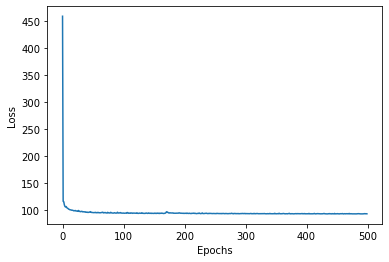

In [7]:
import matplotlib.pyplot as plt
plt.ion()

fig = plt.figure()
plt.plot(train_loss_avg)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

### Evaluation du score sur le Dataset de TEST

In [8]:
# set to evaluation mode
vae.eval()

test_loss_avg, num_batches = 0, 0
for image_batch in test_dataloader:
    
    with torch.no_grad():
    
        #image_batch = image_batch.to(device)
        image_batch = torch.DoubleTensor(image_batch[0])
        Max_image_batch = torch.max(image_batch)
        image_batch = image_batch.view(batch_size,1,2,750)/Max_image_batch
        image_batch = image_batch.float()
        # vae reconstruction
        image_batch_recon, latent_mu, latent_logvar = vae(image_batch)

        # reconstruction error
        loss = vae_loss(image_batch_recon, image_batch, latent_mu, latent_logvar)

        test_loss_avg += loss.item()
        num_batches += 1
    
test_loss_avg /= num_batches
print('average reconstruction error: %f' % (test_loss_avg))

average reconstruction error: 93.090297


# Reconstruction 

Image originale


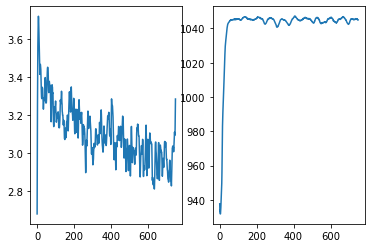

VAE reconstruction:


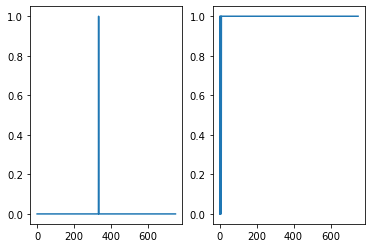

In [9]:
import numpy as np
import matplotlib.pyplot as plt
plt.ion()

import torchvision.utils

vae.eval()

# En entrée, l'image à reconstruire et le modèle utilisé pour la reconstruction



def to_img(x):
    x = x.clamp(0, 1)
    return x

def show_image(img):
    img = to_img(img)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

def visualise_output(images, model):

    with torch.no_grad():
    
        images = images.to(device)
        images, _, _ = model(images)
        images = images.cpu()
        images = to_img(images)
        np_imagegrid = torchvision.utils.make_grid(images[1:50], 10, 5).numpy()
        plt.imshow(np.transpose(np_imagegrid, (1, 2, 0)))
        plt.show()

images = iter(test_dataloader).next()

# Affichage de l'image originale
print('Image originale')

images = torch.DoubleTensor(images[0])
images = images.view(batch_size,1,2,750)
plt.figure()
plt.subplot(1,2,1)
plt.plot((images[0,0,0,:]))
plt.subplot(1,2,2)
plt.plot((images[0,0,1,:]))        
plt.show()

# Reconstruct and visualise the images using the vae
print('VAE reconstruction:')
images, _, _ = vae(images.float())
images = images.detach().numpy()
plt.figure()
plt.subplot(1,2,1)
plt.plot((images[0,0,0,:]))
plt.subplot(1,2,2)
plt.plot((images[0,0,1,:]))        
plt.show()

# Affichage de la courbe de loss 

In [ ]:
import matplotlib.pyplot as plt
plt.ion()

fig = plt.figure()
plt.plot(train_loss_avg)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

# Reconstruction 

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
plt.ion()

import torchvision.utils

vae.eval()

# En entrée, l'image à reconstruire et le modèle utilisé pour la reconstruction



def to_img(x):
    x = x.clamp(0, 1)
    return x

def show_image(img):
    img = to_img(img)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

def visualise_output(images, model):

    with torch.no_grad():
    
        images = images.to(device)
        images, _, _ = model(images)
        images = images.cpu()
        images = to_img(images)
        np_imagegrid = torchvision.utils.make_grid(images[1:50], 10, 5).numpy()
        plt.imshow(np.transpose(np_imagegrid, (1, 2, 0)))
        plt.show()

images, labels = iter(test_dataloader).next()

# Affichage de l'image originale
print('Image originale')
show_image(torchvision.utils.make_grid(images[1:50],10,5))
plt.show()

# Reconstruct and visualise the images using the vae
print('VAE reconstruction:')
visualise_output(images, vae)

# Interpolation dans l'espace latent

In [ ]:
vae.eval()

def interpolation(lambda1, model, img1, img2):
    
    with torch.no_grad():
    
        # latent vector of first image
        img1 = img1.to(device)
        latent_1, _ = model.encoder(img1)

        # latent vector of second image
        img2 = img2.to(device)
        latent_2, _ = model.encoder(img2)

        # interpolation of the two latent vectors
        inter_latent = lambda1* latent_1 + (1- lambda1) * latent_2

        # reconstruct interpolated image
        inter_image = model.decoder(inter_latent)
        inter_image = inter_image.cpu()

        return inter_image
    
# sort part of test set by digit
digits = [[] for _ in range(10)]
for img_batch, label_batch in test_dataloader:
    for i in range(img_batch.size(0)):
        digits[label_batch[i]].append(img_batch[i:i+1])
    if sum(len(d) for d in digits) >= 1000:
        break;

# interpolation lambdas
lambda_range=np.linspace(0,1,10)

fig, axs = plt.subplots(2,5, figsize=(15, 6))
fig.subplots_adjust(hspace = .5, wspace=.001)
axs = axs.ravel()

for ind,l in enumerate(lambda_range):
    inter_image=interpolation(float(l), vae, digits[7][0], digits[1][0])
   
    inter_image = to_img(inter_image)
    
    image = inter_image.numpy()
   
    axs[ind].imshow(image[0,0,:,:], cmap='gray')
    axs[ind].set_title('lambda_val='+str(round(l,1)))
plt.show() 

# Utilisation du VAE comme générateur

Un autoencodeur variationnel peut générer de nouveaux chiffres en tirant des vecteurs latents de la distribution précédente. Les chiffres générés ne sont bien sûr pas parfaits

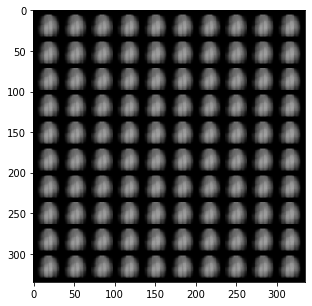

In [37]:
vae.eval()

with torch.no_grad():

    # sample latent vectors from the normal distribution
    latent = torch.randn(128, latent_dims, device=device)

    # reconstruct images from the latent vectors
    img_recon = vae.decoder(latent)
    img_recon = img_recon.cpu()

    fig, ax = plt.subplots(figsize=(5, 5))
    show_image(torchvision.utils.make_grid(img_recon.data[:100],10,5))
    plt.show()

# Espace latent 2D

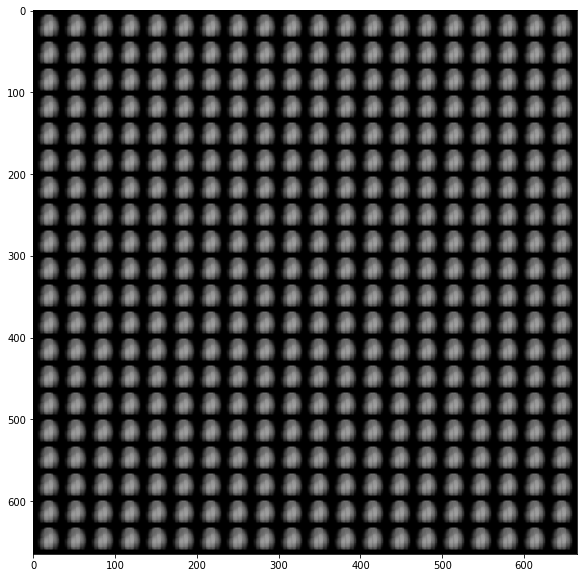

In [38]:
# load a network that was trained with a 2d latent space
if latent_dims != 2:
    print('Please change the parameters to two latent dimensions.')
    
with torch.no_grad():
    
    # create a sample grid in 2d latent space
    latent_x = np.linspace(-1.5,1.5,20)
    latent_y = np.linspace(-1.5,1.5,20)
    latents = torch.FloatTensor(len(latent_y), len(latent_x), 2)
    for i, lx in enumerate(latent_x):
        for j, ly in enumerate(latent_y):
            latents[j, i, 0] = lx
            latents[j, i, 1] = ly
    latents = latents.view(-1, 2) # flatten grid into a batch

    # reconstruct images from the latent vectors
    latents = latents.to(device)
    image_recon = vae.decoder(latents)
    image_recon = image_recon.cpu()

    fig, ax = plt.subplots(figsize=(10, 10))
    show_image(torchvision.utils.make_grid(image_recon.data[:400],20,5))
    plt.show()

In [129]:
13500/750

18.0